In [1]:
import pandas as pd
from kan.custom_utils import (plot_data_per_interval,
                              plot_activation_and_spline_coefficients, get_masks)
import matplotlib.pyplot as plt
import os
import datetime
import json
import numpy as np
plt.rcParams['figure.figsize'] = (11, 6)
plt.rcParams['figure.dpi'] = 75
plt.rcParams['savefig.dpi'] = 75*10

file_name = "exponential_20251027_1729"
groud_truth = lambda x1, x2: np.exp(-2*x1) + x2
# d_opt = pd.read_excel(os.path.join(os.getcwd(), "multkan_sweep_autosave", file_name + ".xlsx"), sheet_name='best_spline_avg_by_params')
d_opt = pd.read_excel(os.path.join(os.getcwd(), "multkan_sweep_autosave", file_name + ".xlsx"), sheet_name='best_avg_by_params')

save_heading = os.path.join(os.getcwd(), "custom_figures", file_name)

x1_grid = np.linspace(-1, 1, 50)
x2_grid = np.linspace(-1, 1, 30)

x1, x2= np.meshgrid(x1_grid, x2_grid)
X = np.stack((x1.flatten(), x2.flatten()), axis=1)
y_mesh = groud_truth(x1, x2)

y = y_mesh.flatten().reshape(-1, 1)


This script is running on cpu.
전체 데이터셋 크기: 1500
훈련셋 크기: 960 (64.0%)
검증셋 크기: 240 (16.0%)
테스트셋 크기: 300 (20.0%)


| train_loss: 6.49e-03 | test_loss: 9.12e-03 | reg: 3.36e-01 | : 100%|█| 50/50 [00:15<00:00,  3.20it


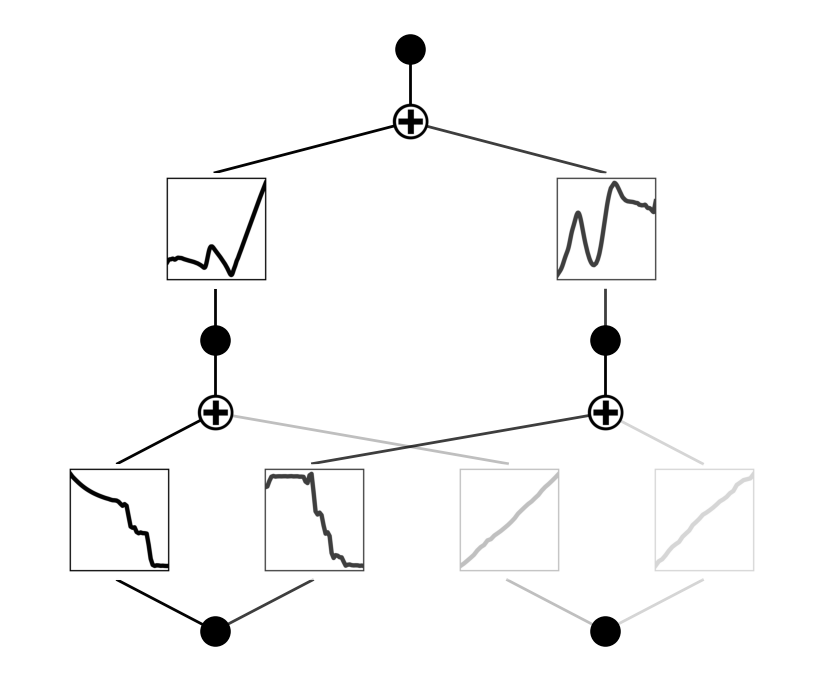

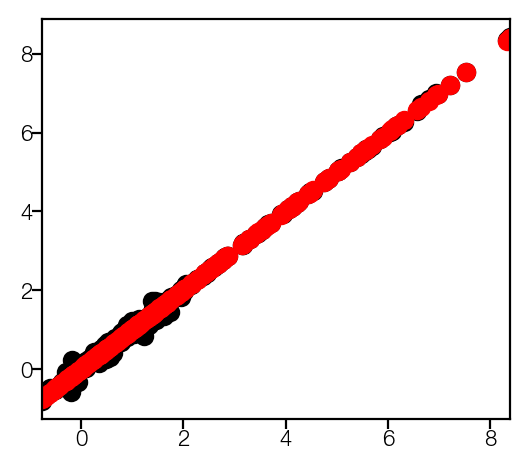

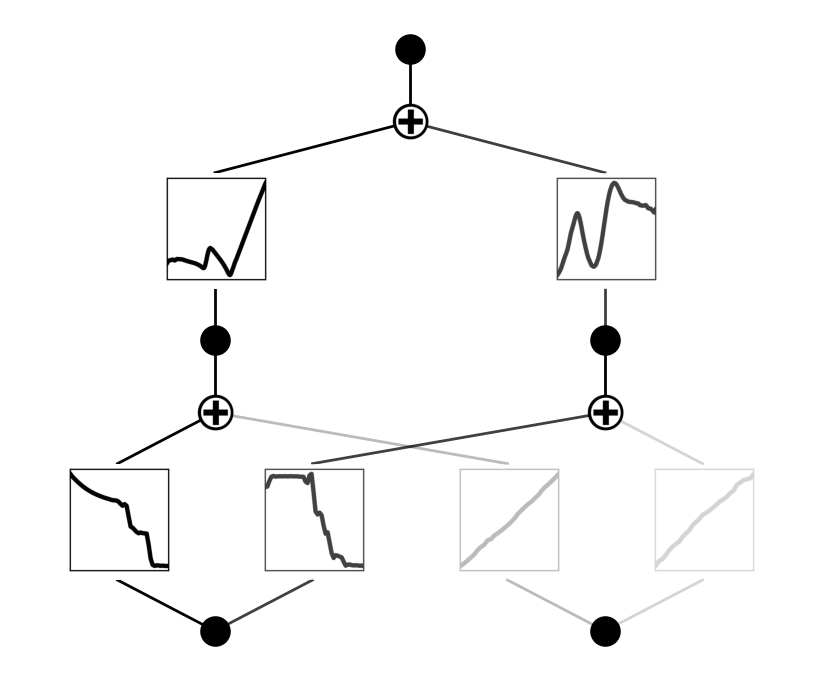

TrialResult(params={'grid': 30, 'k': 3, 'lamb': 0.0001, 'lamb_coef': 0, 'lamb_coefdiff': 0.01, 'lamb_entropy': 0.05, 'lamb_l1': 0.1, 'lr': 0.01, 'mult_arity': 0, 'opt': 'LBFGS', 'prune': True, 'pruning_edge_th': 0.03, 'pruning_node_th': 0.01, 'steps': 50, 'symbolic': False, 'update_grid': True, 'width': [[2, 0], [2, 0], [1, 0]]}, val_loss=0.05487564951181412, train_loss=0.04105754569172859, test_loss=0.05450937896966934, r2_train=0.9987100806773392, r2_val=0.9978639706755704, r2_test=0.9973314572571558, seed=0, device='cpu', spline_train_loss=0.10332214832305908, spline_test_loss=0.10398431867361069)


In [2]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.experiments.multkan_hparam_sweep import evaluate_params, _to_tensor, _build_dataset
from kan.utils import ex_round

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"This script is running on {device}.")

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()
params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}

# params['pruning_node_th'] = 0.001
# params['pruning_edge_th'] = 0.001
#
# params['symbolic'] = True
# params['sym_weight_simple'] = 0.7
# params['sym_a_range'] = (-20, 20)

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm,
    0, scaler_y, device.type,
    save_heading=save_heading
)
model.plot()
plt.show()
print(res)
with open(f"{save_heading}_result.json", 'w') as f:
    json.dump(vars(res), f, indent=4)

In [3]:
model.suggest_symbolic(0, 0, 1, weight_simple=0.7, a_range=(-20, 20))
# model.suggest_symbolic(0, 0, 0, weight_simple=0.7, a_range=(-20, 20))

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0      sin    0.974154 -5.273367           2                2   -0.182010
1      cos    0.974154 -5.273360           2                2   -0.182008
2        x    0.843333 -2.674136           1                1   -0.102241
3        0    0.000000  0.000014           0                0    0.000004
4     tanh    0.985536 -6.110367           3                3    0.266890


('sin',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9741541743278503,
 2)

In [4]:
sym_fun = ex_round(model.symbolic_formula()[0][0], 4)
print(sym_fun)

0


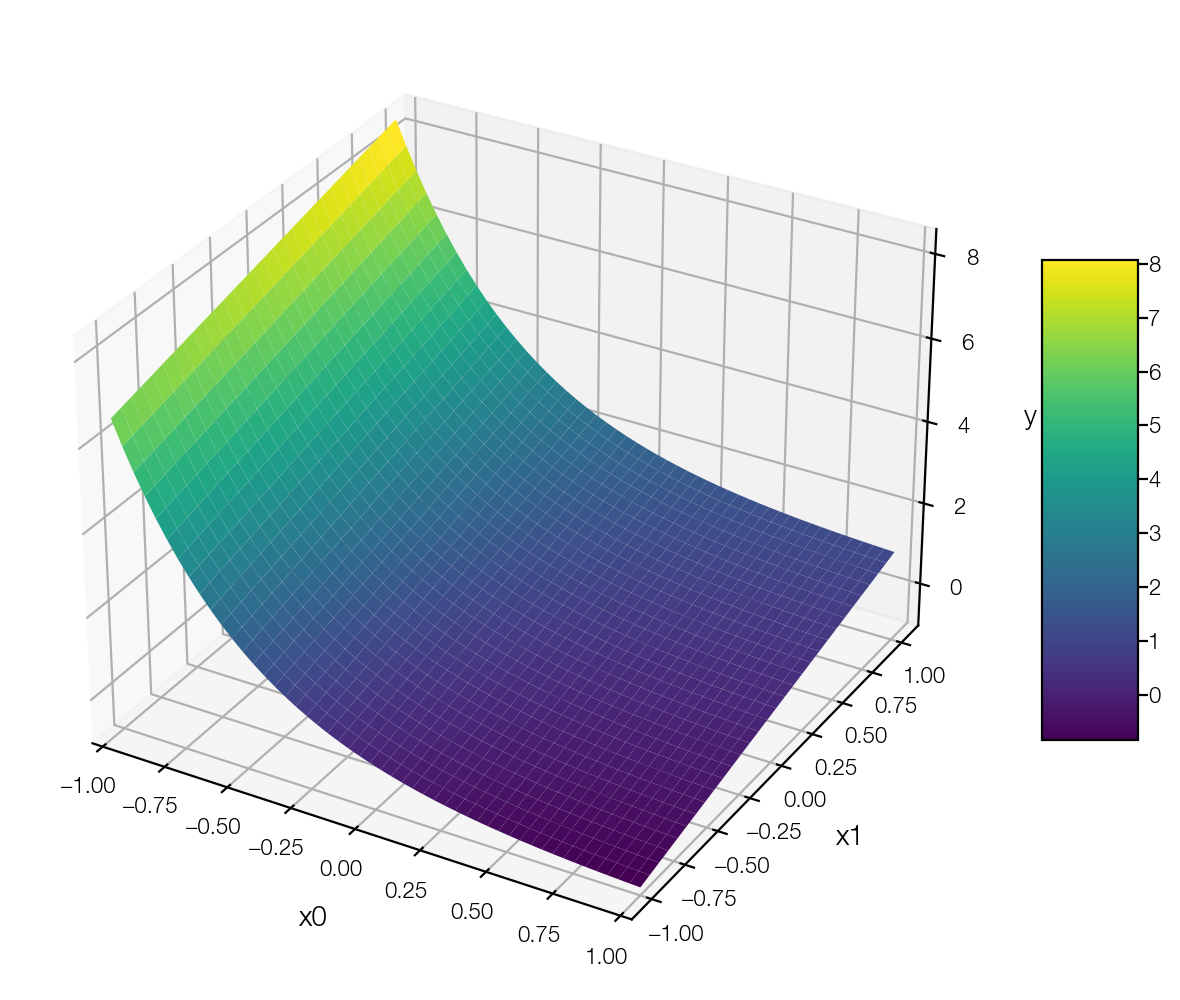

In [5]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x1, x2, y_mesh, cmap='viridis', edgecolor='none')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('y')
fig.colorbar(surface, shrink=0.5, aspect=5)
plt.savefig(f"{save_heading}_ground_truth.png")
plt.show()

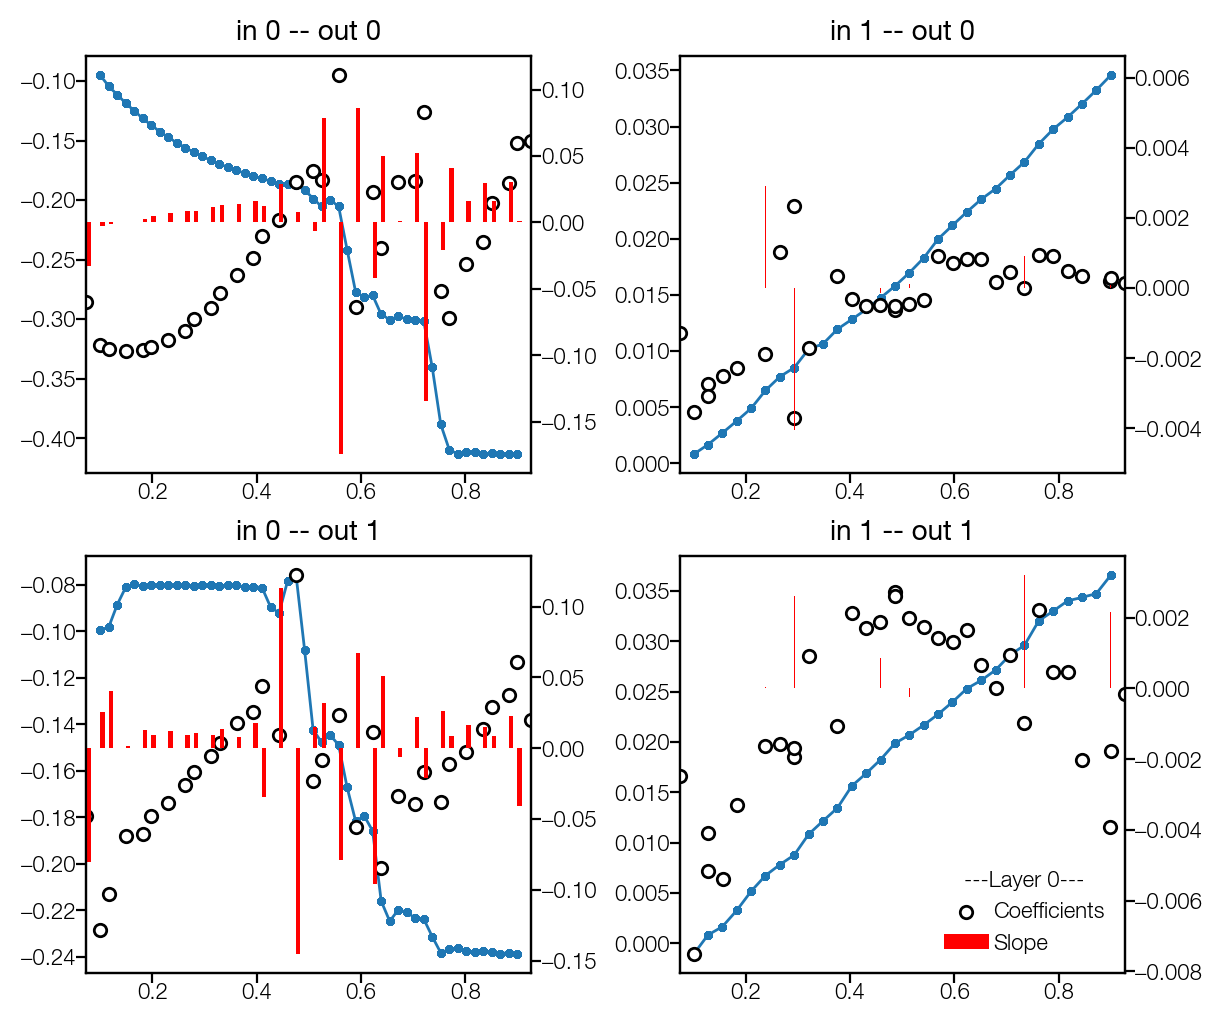

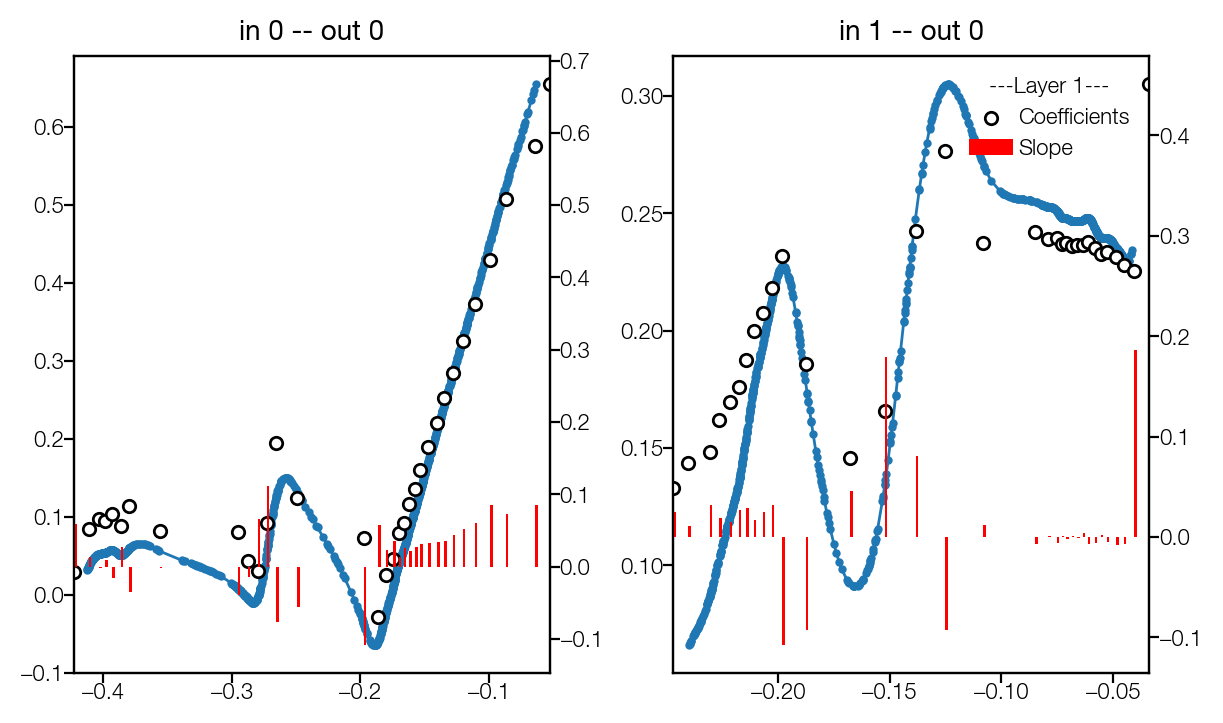

[<Figure size 1200x1000 with 8 Axes>, <Figure size 1200x700 with 4 Axes>]

In [6]:
plot_activation_and_spline_coefficients(model, save_heading=save_heading, x=dataset, layers=None)

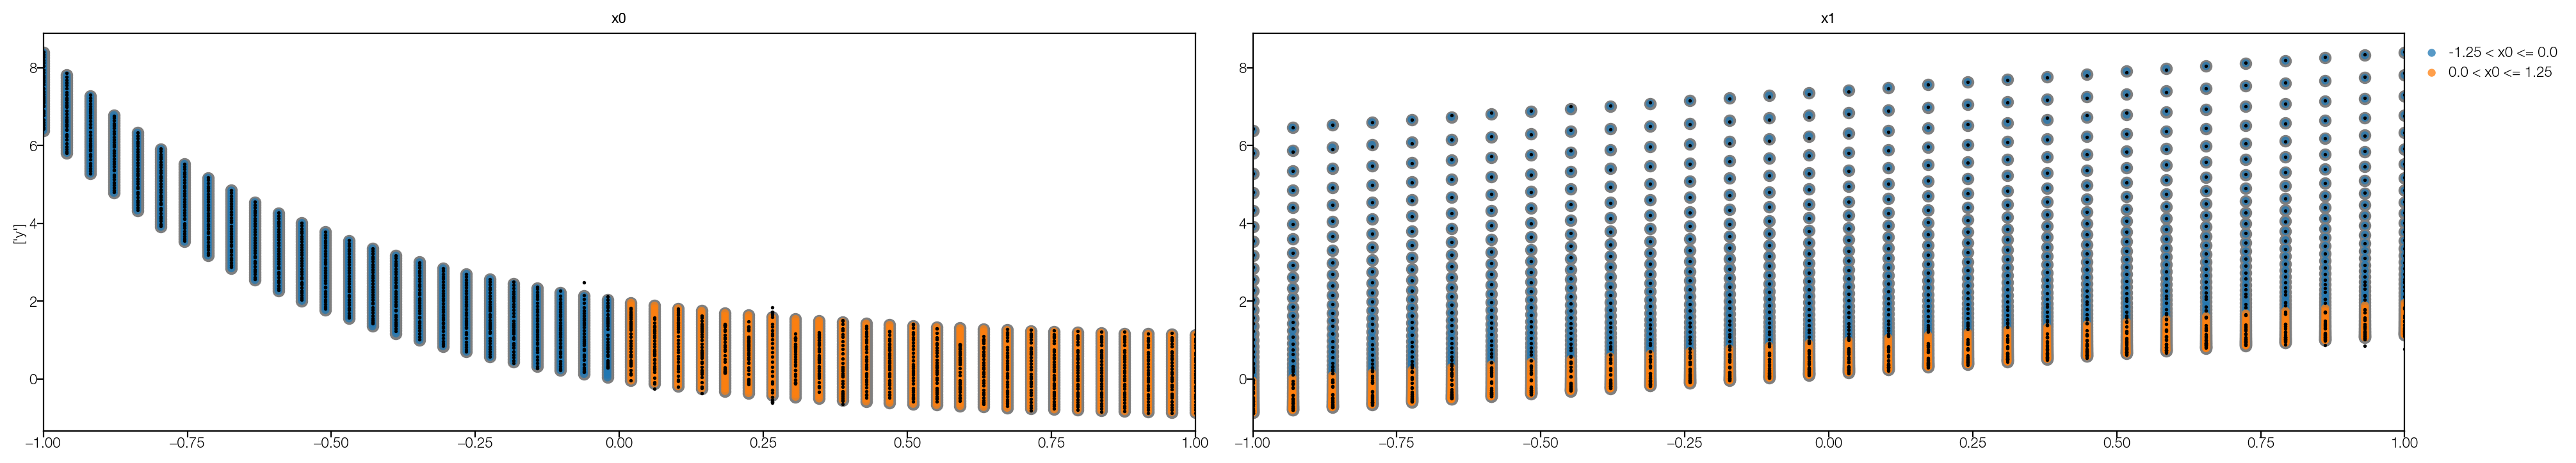

In [7]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)
name_X = [f'x{idx}' for idx in range(X_norm.shape[1])]
name_y = ['y']
y_pred_norm = model(_to_tensor(X_norm, device)).detach().cpu().numpy()
y_pred = scaler_y.inverse_transform(y_pred_norm)

# mask_idx = 1
# mask_interval = [-1 + 0.5 * i for i in range(5)]
mask_idx = 0
# mask_interval = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
mask_scaled_interval = [0, 0.5, 1]
mask_interval = [scaler_X.inverse_transform(np.array([[x0, x0]]))[0, mask_idx] for x0 in mask_scaled_interval]

fig_x1, ax_x1 = plot_data_per_interval(X, y, name_X, name_y, mask_idx, mask_interval)
plt.savefig(f"{save_heading}_data_colored.png")
for idx_x in range(X.shape[1]):
    ax_x1[idx_x].scatter(X[:, idx_x], y_pred, color='k', s=.9, label='Prediction')
plt.savefig(f"{save_heading}_data_and_prediction.png")
plt.show()

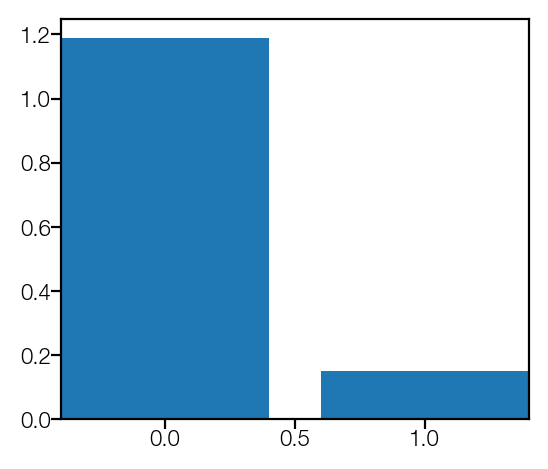

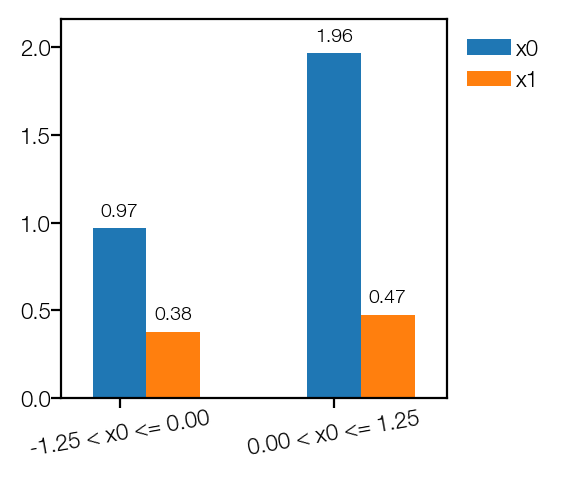

[array([0.9683186 , 0.37687492], dtype=float32), array([1.9641895 , 0.47468832], dtype=float32)]


In [8]:
scores_tot = model.node_scores[0].detach().cpu().numpy()
fig, ax = plt.subplots()
ax.bar(list(range(scores_tot.shape[0])), scores_tot.tolist())
plt.savefig(f"{save_heading}_scores_L0.png")
plt.show()

masks = get_masks(X, mask_idx, mask_interval)
scores_interval = []
acts_interval = []
for mask in masks:
    if np.any(mask):
        x_masked = X[mask, :]   # 이게 아니라 fabricated, 임의의 input을 주게 되면 어떨까?
        x_norm_masked = scaler_X.transform(x_masked)
        x_tensor_masked = torch.tensor(x_norm_masked, dtype=torch.float32, device=device)
        model.forward(x_tensor_masked)
        acts_interval.append(model.acts)
        scores_interval.append(model.feature_score.detach().cpu().numpy().copy())
    else:
        scores_interval.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots()
xticks = np.arange(len(masks))
xticklabels = [f'{lb:.2f} < x{mask_idx} <= {ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.savefig(f"{save_heading}_scores_L0_interval.png")
plt.show()
print(scores_interval)

with open(f"{save_heading}_sym_res.txt", 'w') as f:
    f.write(f"{sym_fun}\n")
